In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os

path = '/content/drive/MyDrive/Obeject_trajectory_research'
print(os.listdir(path))

['Random_coordinates.xlsx', 'Distances.xlsx', 'points_list.xlsx', 'Multiple Random Object Trajectories (1).ipynb', 'df_results_arr_real_3500_4500.xlsx', 'df_results_arr_imag_3500_4500.xlsx', 'df_results_arr_real_4500_5500.xlsx', 'df_results_arr_imag_4500_5500.xlsx', 'df_results_arr_real_5500_6500.xlsx', 'df_results_arr_imag_5500_6500.xlsx', 'Multiple Random Object Trajectories.ipynb', 'MLP model.ipynb']


In [7]:
import pandas as pd
df_real = pd.read_excel('/content/drive/MyDrive/Obeject_trajectory_research/df_results_arr_real.xlsx')
df_real.head()

,0,1,2,3,4,5,6,7,8,9,...,501,502,503,504,505,506,507,508,509,510
0,0.000432,0.006607,0.039193,-0.143935,-1.767283,-6.526934,-11.184092,-12.711309,-9.456711,-1.641575,...,0.006607,0.039193,-0.143935,-1.767283,-6.526934,-11.184092,-12.711309,-9.456711,-1.641575,95.041718
1,-0.000030,0.011446,0.042073,-0.231437,-2.391988,-6.892663,-10.779109,-10.067949,-7.667257,-1.929023,...,0.011446,0.042073,-0.231437,-2.391988,-6.892663,-10.779109,-10.067949,-7.667257,-1.929023,96.968796
2,0.000256,0.008298,0.047472,-0.428711,-2.925494,-7.885454,-12.822762,-11.010488,-5.186280,2.668768,...,0.008298,0.047472,-0.428711,-2.925494,-7.885454,-12.822762,-11.010488,-5.186280,2.668768,98.098419
3,0.000104,0.010083,0.060578,-0.460531,-3.192271,-8.206146,-12.080729,-11.279043,-4.986012,4.267717,...,0.010083,0.060578,-0.460531,-3.192271,-8.206146,-12.080729,-11.279043,-4.986012,4.267717,73.169739
4,-0.000003,0.007162,0.045818,-0.339847,-2.584204,-6.577459,-10.365834,-10.993408,-7.023180,1.436533,...,0.007162,0.045818,-0.339847,-2.584204,-6.577459,-10.365834,-10.993408,-7.023180,1.436533,83.030594


In [8]:
df_imag = pd.read_excel('/content/drive/MyDrive/Obeject_trajectory_research/df_results_arr_imag.xlsx')
len(df_imag)

6500

In [9]:
df_distances = pd.read_excel('/content/drive/MyDrive/Obeject_trajectory_research/Distances.xlsx')[['Distances']]
df_distances.head()

,Distances
0,1291.451524
1,1236.652469
2,884.001201
3,381.396786
4,1122.314349


#### Prepare Training set and Test set

In [ ]:
#from sklearn.model_selection import train_test_split

In [ ]:
#real_train, real_test, imag_train, imag_test, y_train, y_test = train_test_split(df_real, df_imag, df_distances[:len(df_imag)], test_size=0.33, random_state=42)


In [ ]:
'''
real_train = real_train.sort_index()
imag_train = imag_train.sort_index()
y_train = y_train.sort_index()
'''

In [ ]:
'''
real_test = real_train.sort_index()
imag_test = imag_train.sort_index()
y_test = y_train.sort_index()
'''

In [10]:
split_point = int(len(df_real) * 0.8)

In [11]:
real_train = df_real[:split_point]
imag_train = df_imag[:split_point]
y_train = df_distances[:len(real_train)]

In [12]:
real_test = df_real[split_point:]
imag_test = df_imag[split_point:]
y_test = df_distances[len(real_train):len(df_real)]

#### Buid MLP Model

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

In [14]:
real_tensor = torch.tensor(real_train.to_numpy(), dtype=torch.float32)
imag_tensor = torch.tensor(imag_train.to_numpy(), dtype=torch.float32)
y_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)

X = torch.cat([real_tensor, imag_tensor], dim=1)

# Define the MLP model
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Initialize the model
input_size = X.shape[1]  # Number of input features
hidden_size = 64         # Number of hidden units
output_size = 1          # Output units for regression (or change if classification)

model = MLPModel(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 6000
for epoch in range(num_epochs):
    # Forward pass: Compute predicted y by passing X to the model
    outputs = model(X)
    loss = criterion(outputs, y_tensor)  # Compute the loss

    # Backward pass and optimization
    optimizer.zero_grad()  # Clear the gradients
    loss.backward()        # Backpropagate the gradients
    optimizer.step()       # Update the model weights

    # Print loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Model is trained; now you can make predictions
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    predictions = model(X).numpy()  # Convert to numpy array if needed

# Optionally convert predictions to a DataFrame for easier processing
predictions_df = pd.DataFrame(predictions, columns=['Predictions'])


Epoch [100/6000], Loss: 276007.9688
Epoch [200/6000], Loss: 216072.2656
Epoch [300/6000], Loss: 177227.3281
Epoch [400/6000], Loss: 134676.3906
Epoch [500/6000], Loss: 93708.4453
Epoch [600/6000], Loss: 64962.8125
Epoch [700/6000], Loss: 50542.9297
Epoch [800/6000], Loss: 43996.7305
Epoch [900/6000], Loss: 40368.3633
Epoch [1000/6000], Loss: 37935.0664
Epoch [1100/6000], Loss: 36119.0391
Epoch [1200/6000], Loss: 34667.3516
Epoch [1300/6000], Loss: 33447.4375
Epoch [1400/6000], Loss: 32374.4746
Epoch [1500/6000], Loss: 31391.1016
Epoch [1600/6000], Loss: 30466.6641
Epoch [1700/6000], Loss: 29567.5078
Epoch [1800/6000], Loss: 28716.4316
Epoch [1900/6000], Loss: 27880.4004
Epoch [2000/6000], Loss: 27044.7051
Epoch [2100/6000], Loss: 26197.9102
Epoch [2200/6000], Loss: 25372.4902
Epoch [2300/6000], Loss: 24564.2109
Epoch [2400/6000], Loss: 23764.5391
Epoch [2500/6000], Loss: 22967.0234
Epoch [2600/6000], Loss: 22161.1191
Epoch [2700/6000], Loss: 21346.6992
Epoch [2800/6000], Loss: 20530.60

In [15]:
with torch.no_grad():
    predictions = model(X)

In [16]:
predictions = pd.DataFrame(predictions)
merge_train_pred = pd.concat([df_distances[:len(predictions)], predictions], axis = 1, join = 'outer')

In [17]:
merge_train_pred[:20]

,Distances,0
0,1291.451524,1297.141602
1,1236.652469,1292.319946
2,884.001201,880.882324
3,381.396786,355.094940
4,1122.314349,1103.907227
5,468.251803,488.795593
6,1072.303073,1047.302246
7,758.309800,789.185486
8,569.520065,445.174316
9,860.929271,794.265259


In [18]:
import matplotlib.pyplot as plt
import numpy as np

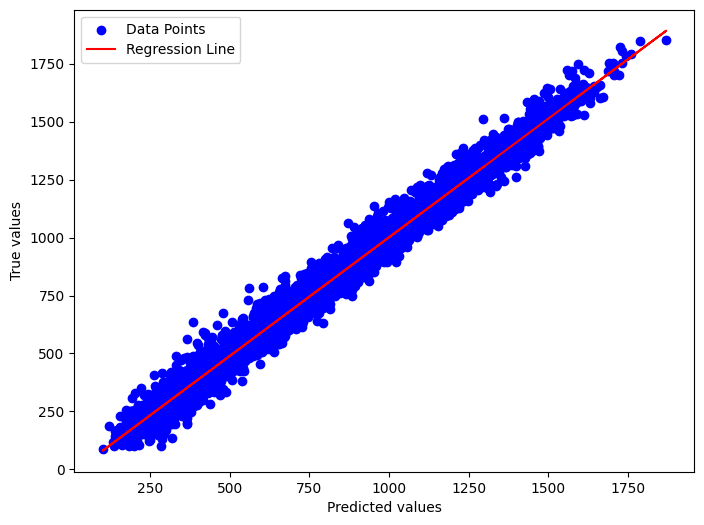

In [19]:
plt.figure(figsize=(8, 6))
plt.scatter(merge_train_pred[0], merge_train_pred['Distances'], color='blue', label='Data Points')

slope, intercept = np.polyfit(merge_train_pred[0], merge_train_pred['Distances'], 1)
regression_line = slope * merge_train_pred[0] + intercept

plt.plot(merge_train_pred[0], regression_line, color='red', label='Regression Line')

plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.legend()

plt.show()

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(df_distances[:len(predictions)], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(df_distances[:len(predictions)], predictions)
r2 = r2_score(df_distances[:len(predictions)], predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

MSE: 2345.9544423021903
RMSE: 48.43505385877247
MAE: 37.43895868606683
R²: 0.9844659720447329


In [21]:
real_tensor = torch.tensor(real_test.to_numpy(), dtype=torch.float32)
imag_tensor = torch.tensor(imag_test.to_numpy(), dtype=torch.float32)
y_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

X = torch.cat([real_tensor, imag_tensor], dim=1)

In [22]:
with torch.no_grad():
    predictions = model(X)

In [23]:
predictions = pd.DataFrame(predictions)
merge_test_pred = pd.concat([y_test.reset_index(drop = True), predictions], axis = 1, join = 'outer')

In [24]:
merge_test_pred

,Distances,0
0,978.001898,801.773682
1,1362.869815,1393.695435
2,206.473978,526.083984
3,1476.749934,1740.550537
4,1144.495114,1290.514771
...,...,...
1295,493.724199,303.655487
1296,1082.231947,865.661438
1297,576.622889,347.194275
1298,1062.866307,728.788147


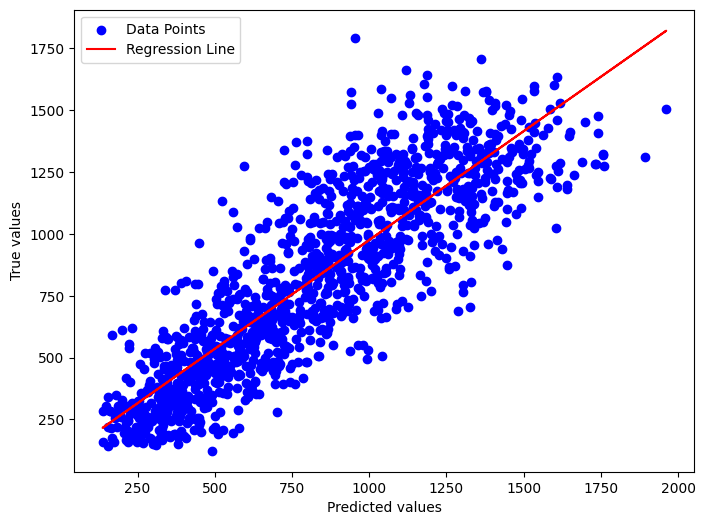

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(merge_test_pred[0], merge_test_pred['Distances'], color='blue', label='Data Points')

slope, intercept = np.polyfit(merge_test_pred[0], merge_test_pred['Distances'], 1)
regression_line = slope * merge_test_pred[0] + intercept

plt.plot(merge_test_pred[0], regression_line, color='red', label='Regression Line')

plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.legend()

plt.show()

In [26]:
mse = mean_squared_error(df_distances[:len(predictions)], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(df_distances[:len(predictions)], predictions)
r2 = r2_score(df_distances[:len(predictions)], predictions)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

MSE: 289972.9267152528
RMSE: 538.4913432129182
MAE: 437.56407185689807
R²: -0.9524538776911371
